[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL Model MSE: 41.08559497335709
MSFT Model MSE: 141.89761298591586
GOOGL Model MSE: 1.3656007917863873
AMZN Model MSE: 1.7892159032747181
TSLA Model MSE: 30.488199828124745
{'AAPL': -0.07111461202826581, 'MSFT': -0.096377486299187, 'GOOGL': -0.009830116123653755, 'AMZN': 0.004143593698845297, 'TSLA': -0.0025542874354788346}
Optimized Weights: [0.07768223 0.28885205 0.21127344 0.36757444 0.05461784]
Expected Portfolio Return: -0.03405644890320033
Expected Portfolio Variance: 0.00033841735738869685


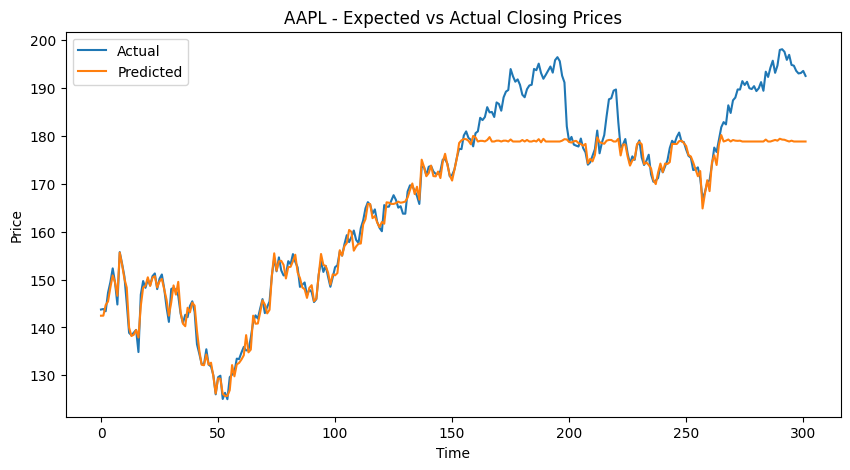

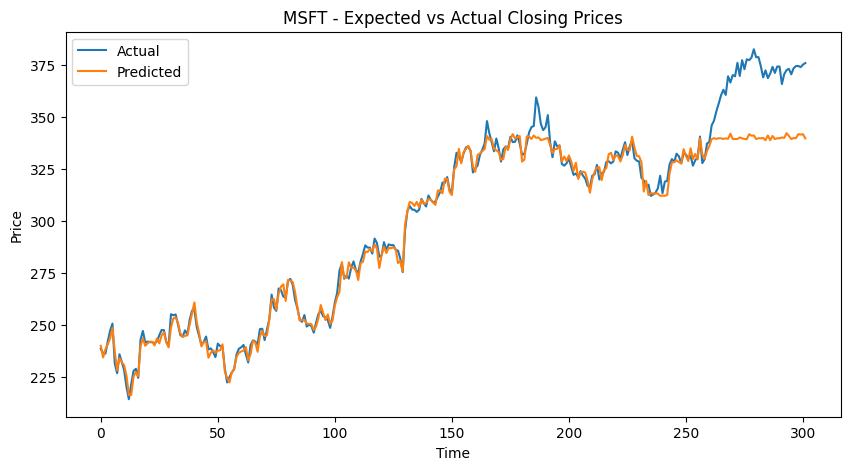

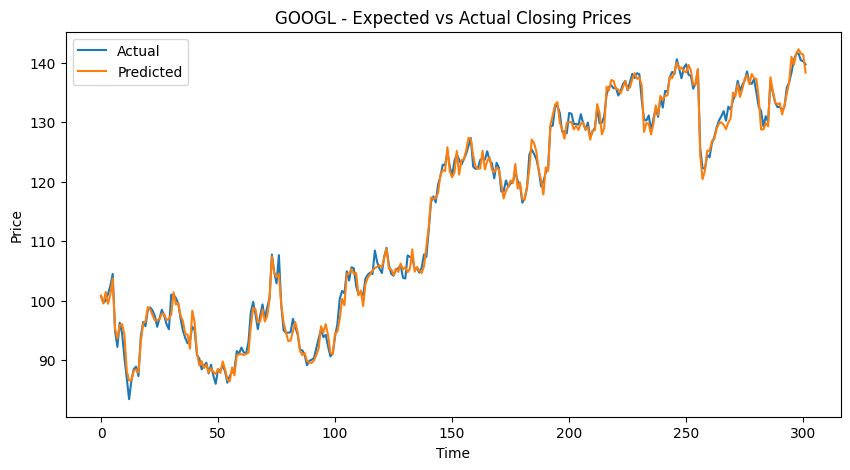

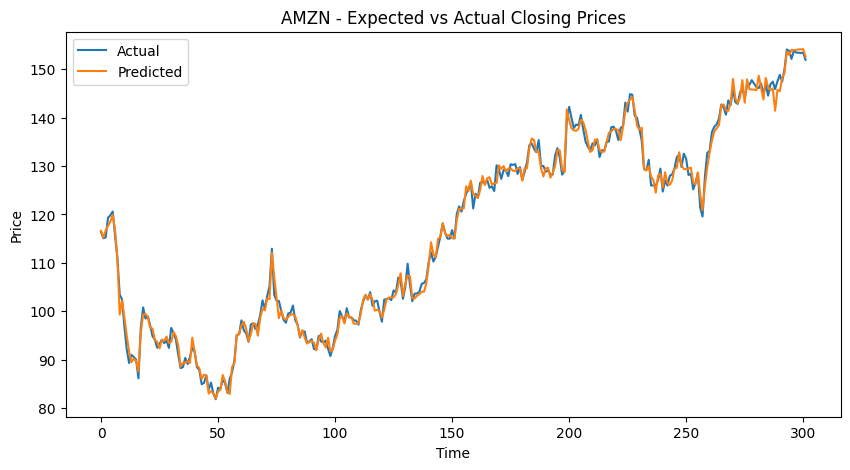

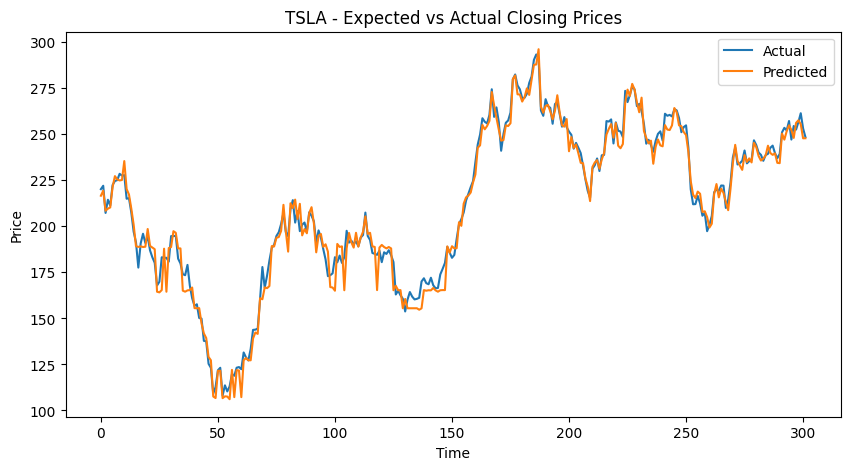

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import scipy.optimize as sco
import matplotlib.pyplot as plt

# Fetch historical data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = {ticker: yf.download(ticker, start='2018-01-01', end='2023-12-31') for ticker in tickers}

# Preprocess each stock's data
for stock in data.keys():
    df = data[stock]
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    data[stock] = df

# Train XGBoost models and make predictions
models = {}
future_returns = {}
predictions = {}
actuals = {}

for stock in data.keys():
    df = data[stock]
    X = df[['Open', 'High', 'Low', 'Volume']].values
    y = df['Close'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    models[stock] = model
    
    y_pred = model.predict(X_test)
    predictions[stock] = y_pred
    actuals[stock] = y_test
    
    print(f'{stock} Model MSE: {mean_squared_error(y_test, y_pred)}')
    
    # Predict future return
    X_future = df[['Open', 'High', 'Low', 'Volume']].values[-1].reshape(1, -4)
    future_price = model.predict(X_future)[0]
    last_close = df['Close'].values[-1]
    future_return = (future_price - last_close) / last_close
    future_returns[stock] = future_return

print(future_returns)

# Portfolio construction
returns = np.array(list(future_returns.values()))
cov_matrix = np.cov([data[stock]['Return'].values for stock in data.keys()])
num_assets = len(returns)

# Initialize weights
weights = np.random.random(num_assets)
weights /= np.sum(weights)

# Define functions to calculate portfolio return and variance
def portfolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Optimize portfolio
def minimize_variance(weights):
    return portfolio_variance(weights, cov_matrix)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

opt_results = sco.minimize(minimize_variance, weights, bounds=bounds, constraints=constraints)

opt_weights = opt_results.x
opt_portfolio_return = portfolio_return(opt_weights, returns)
opt_portfolio_variance = portfolio_variance(opt_weights, cov_matrix)

print('Optimized Weights:', opt_weights)
print('Expected Portfolio Return:', opt_portfolio_return)
print('Expected Portfolio Variance:', opt_portfolio_variance)

# Plot expected vs actual closing prices for each stock
for stock in data.keys():
    plt.figure(figsize=(10, 5))
    plt.plot(actuals[stock], label='Actual')
    plt.plot(predictions[stock], label='Predicted')
    plt.title(f'{stock} - Expected vs Actual Closing Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
